# Accessing and analysing a REMO dataset at DKRZ

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/remo-rcm/pyremo/blob/master/notebooks/remo-dataset.ipynb)

In this notebook we want to show some typical data analysis that might be useful to look at after or during a REMO run. Some of the code in this notebook in actually implemented in the `pyremo.analysis` module. However, we will show a little more in detail how we can access and evaluate a REMO dataset here so you can tweak this to your own analysis.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import pyremo as pr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We will do the processing at DKRZ where we reserve a shared node for distributed computing with dask.

In [2]:
from dask.distributed import Client, progress

client = Client()
client

<Client: 'tcp://127.0.0.1:35221' processes=7 threads=28, memory=50.00 GiB>

## Access and preparation of REMO output

For this notebook, we use 30 years of preliminary test results from a REMO run using ERA5 data as lateral boundary forcings. We will only use monthly mean data for this analysis, so let's catch that data from the filesystem:

In [3]:
import glob

pattern = "/work/ch0636/remo/tutorial/tutorial_REMO2020/example-dataset/*/e056000m*.nc"
filenames = glob.glob(pattern)
filenames.sort()
filenames[:5]

['/work/ch0636/remo/tutorial/tutorial_REMO2020/example-dataset/1979/e056000m197901.nc',
 '/work/ch0636/remo/tutorial/tutorial_REMO2020/example-dataset/1979/e056000m197902.nc',
 '/work/ch0636/remo/tutorial/tutorial_REMO2020/example-dataset/1979/e056000m197903.nc',
 '/work/ch0636/remo/tutorial/tutorial_REMO2020/example-dataset/1979/e056000m197904.nc',
 '/work/ch0636/remo/tutorial/tutorial_REMO2020/example-dataset/1979/e056000m197905.nc']

We will define a slightly different function for opening the monthly dataset that is based on some [xarray discussions on github](https://github.com/pydata/xarray/issues/1385#issuecomment-561920115).

In [4]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={"time": 1},
    coords="minimal",
    compat="override",
    drop=None,
    **kwargs,
):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """

    def drop_all_coords(ds):
        # ds = ds.drop(drop)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [5]:
%time ds = open_mfdataset(filenames, parallel=True, chunks='auto')

CPU times: user 15.9 s, sys: 577 ms, total: 16.5 s
Wall time: 24.9 s


We now have our monthly REMO output in one dataset. Please remember, that [xarray uses dask under the hood](http://xarray.pydata.org/en/stable/user-guide/dask.html) (if you have installed it!) which means that we can easily work and analyze large datasets that would normally not fit into our memory (or because we simply don't want all data loaded and slow us down).

For historical reason, the current REMO version sets the day of the month to 0 for monthly means. This is not compatible, e.g., with standard datetime formats. We provided a function to correct the time axis here.

In [6]:
ds = pr.parse_dates(ds)

Now, we have a reasonable time axis in the dataset that makes analysis much easier:

In [7]:
ds.time[:5]

<xarray.DataArray 'time' (time: 5)>
array(['1979-01-15T00:00:00.000000000', '1979-02-15T00:00:00.000000000',
       '1979-03-15T00:00:00.000000000', '1979-04-15T00:00:00.000000000',
       '1979-05-15T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-15 1979-02-15 ... 1979-05-15

Now, let's have a look at the dataset:

In [8]:
ds

<xarray.Dataset>
Dimensions:                     (rlon: 433, rlat: 433, meansea: 1,
                                 height10m: 1, height2m: 1, lev_4: 1, nhyi: 28,
                                 nhym: 27, lev_5: 1, snlevs: 3, time: 456)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * meansea                     (meansea) float64 0.0
  * height10m                   (height10m) float64 10.0
  * height2m                    (height2m) float64 2.0
  * lev_4                       (lev_4) float64 1.0
  * lev_5                       (lev_5) float64 27.0
  * snlevs                      (snlevs) float64 1.0 2.0 3.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) datetime64[ns] 1979-01-15 ... 2016-12-15
Dimensions without coordinates: nhyi, nhym
Data variables: (12/129)
    hyai                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hybi                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hyam                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    hybm                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    rotated_latitude_longitude  |S1 ...
    QDB                         (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    ...                          ...
    ALSOFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    USTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    VSTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    EVAPFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    TMCHFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    SNMLRHO                     (time, snlevs, rlat, rlon) float32 dask.array<chunksize=(1, 3, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              preprocessing with pyremo = 0.1.0
    institution:          European Centre for Medium-Range Weather Forecasts
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    _NCProperties:        version=2,netcdf=4.7.4,hdf5=1.10.6
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    git_branch:           nc_meta
    git_hash:             c4ee7f4
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

You can see that we got 129 data variables and a lot of coordinates. We will focus on some common variables for analysis. However, first, let's look at the size of the dataset.

In [9]:
ds.nbytes / 1.0e9  # in GB

43.092483281

Not too bad, that much data would fit into the memory, e.g. at DKRZ, but probably would be too large for a laptop. It's good that we load that dataset lazily and will only load data if we need it.

It's also handy to grep the pole information about the grid mapping from the dataset for plotting:

In [10]:
pole = (
    ds.rotated_latitude_longitude.grid_north_pole_longitude,
    ds.rotated_latitude_longitude.grid_north_pole_latitude,
)
pole

(-162.0, 39.25)

Before we regrid our REMO dataset to the grid of an observational dataset, we will add a land sea mask so that the `xesmf` regridder knows about valid temperature values and we can [avoid regridding artifacts](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html). It's also useful to have the topography in the dataset, e.g., we can use that for a height correction.

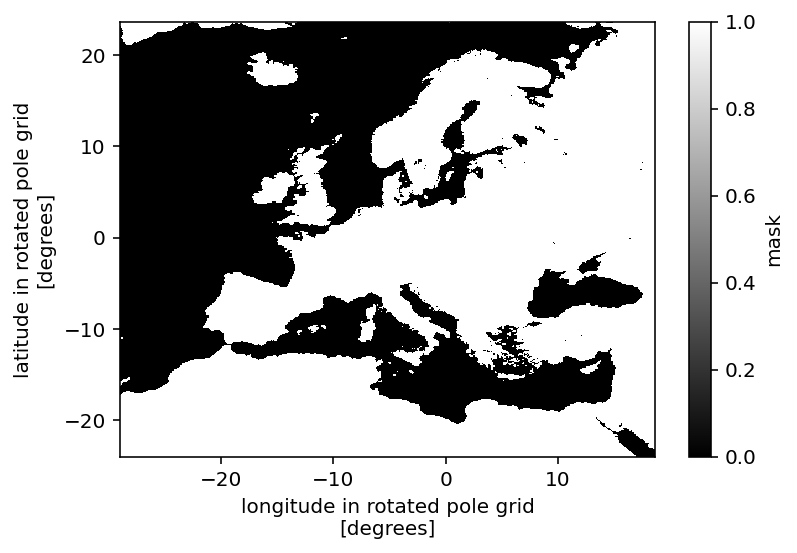

In [11]:
mask = xr.where(pr.data.surflib("EUR-11").BLA > 0, 1, 0)
topo = pr.data.surflib("EUR-11").FIB
mask.name = "mask"
topo.name = "topo"
ds = xr.merge([ds, mask, topo], compat="override", join="override")
ds.mask.plot(cmap="binary_r")

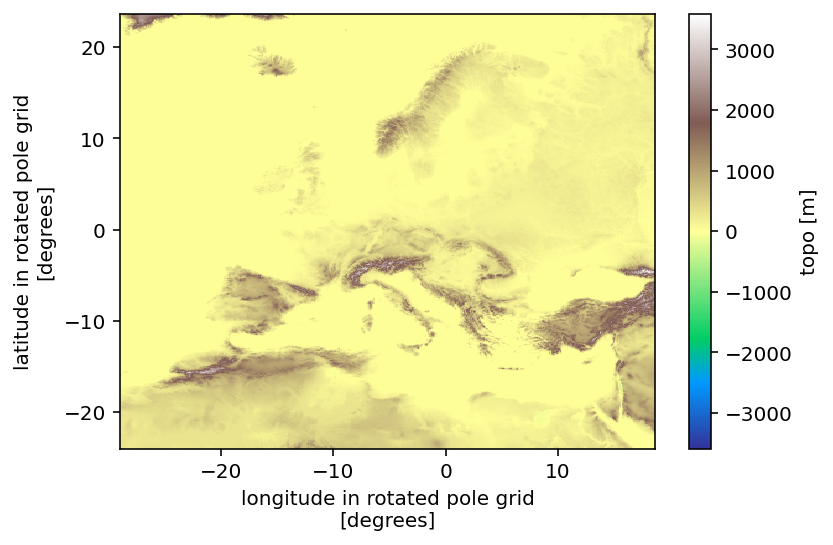

In [12]:
ds.topo.plot(cmap="terrain")

## Spin up

It's always useful to look at the soil temperatures. During the run, the soil has to get into an equilibrium with the atmospheric temperature to *forget* the initial conditions.

Let's look at the following variables:

In [13]:
temp_vars = ["TS", "TSL", "TEMP2", "TSN", "TD3", "TD4", "TD5"]

We will extract those variables from the big dataset and stuff them into a coordinate so that we can easily plot them.

In [14]:
dim = xr.DataArray(data=temp_vars, dims="var", name="var")
temps = xr.concat([ds[var] - 273.5 for var in temp_vars], dim=dim)
temps.name = "temperatures"
temps

<xarray.DataArray 'temperatures' (var: 7, time: 456, rlat: 433, rlon: 433,
                                  height2m: 1)>
dask.array<concatenate, shape=(7, 456, 433, 433, 1), dtype=float32, chunksize=(1, 1, 433, 433, 1), chunktype=numpy.ndarray>
Coordinates:
  * height2m  (height2m) float64 2.0
  * rlon      (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat      (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time      (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2016-12-15
  * var       (var) <U5 'TS' 'TSL' 'TEMP2' 'TSN' 'TD3' 'TD4' 'TD5'

Great, now lets' compute the spatial means (or field mean) for the 10 years...

In [15]:
weight = np.cos(np.deg2rad(ds.rlat))
temps_mean = temps.weighted(weight).mean(dim=("rlat", "rlon"))
temps_mean

<xarray.DataArray 'temperatures' (var: 7, time: 456, height2m: 1)>
dask.array<truediv, shape=(7, 456, 1), dtype=float64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * height2m  (height2m) float64 2.0
  * time      (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2016-12-15
  * var       (var) <U5 'TS' 'TSL' 'TEMP2' 'TSN' 'TD3' 'TD4' 'TD5'

You can see that the data is still nicely chunked. We have not triggered any computation yet because we didn't actually look at the data yet. But now, we want to plot the data. To show the computation here, we will explicitly trigger it! Usually, you could just go on with plotting and the computation is done automatically.

In [16]:
%time temps_mean_ = temps_mean.compute()  # start computation

CPU times: user 21.2 s, sys: 643 ms, total: 21.8 s
Wall time: 27.8 s


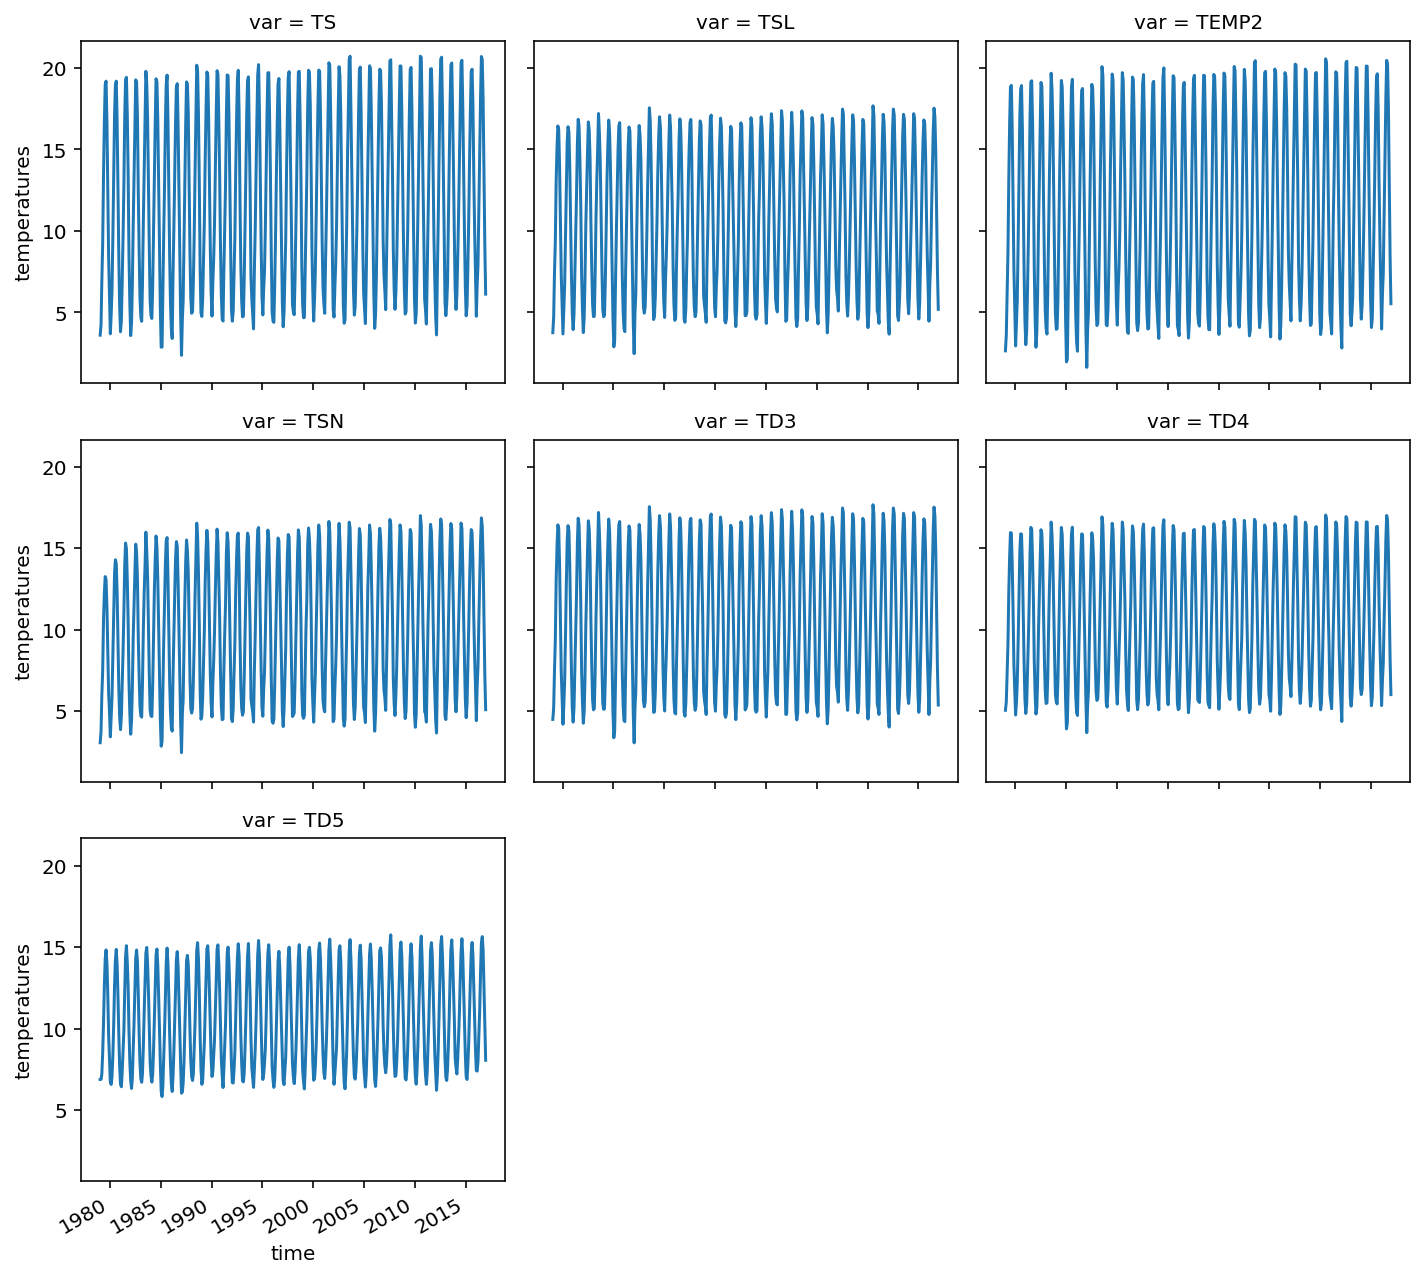

In [17]:
temps_mean_.plot(col="var", col_wrap=3)

We can see that the soil temperatures seem to be fine and in equilibrium with the atmosphere!

## Seasonal means

First, let's define a function to conveniently plot all four seasons.

In [18]:
def plot_seasons(
    da,
    transform,
    projection=None,
    vmin=None,
    vmax=None,
    extent=None,
    cmap="bwr",
    borders=False,
):
    """plot seasonal means"""

    if projection is None:
        projection = transform

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        ncols=2, nrows=2, subplot_kw={"projection": projection}, figsize=(14, 10)
    )

    axes = (ax1, ax2, ax3, ax4)
    for ax in axes:
        # ax.set_axis_off()
        if extent is not None:
            ax.set_extent(*extent)
        ax.gridlines(
            draw_labels=True,
            linewidth=0.5,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )
        ax.coastlines(resolution="50m", color="black", linewidth=1)
        if borders is True:
            ax.add_feature(cf.BORDERS)
    for season, ax in zip(da.season, axes):
        im = da.sel(season=season).plot(
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            transform=transform,
            add_colorbar=False,
        )
    cbar = fig.colorbar(im, ax=axes)
    return plt


rotated_pole = ccrs.RotatedPole(pole[0], pole[1])
extent = ([ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()], rotated_pole)

Now, we compute seasonal means with a simple groupy approach.

In [19]:
temp2_seasmean = ds.TEMP2.groupby("time.season").mean(dim="time")
%time temp2_seasmean_ = temp2_seasmean.compute()  # start computation

CPU times: user 1.48 s, sys: 79.9 ms, total: 1.56 s
Wall time: 4.14 s


We can have a look using our nice plotting function.

<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/pyremo-dev/lib/python3.9/site-packages/matplotlib/pyplot.py'>

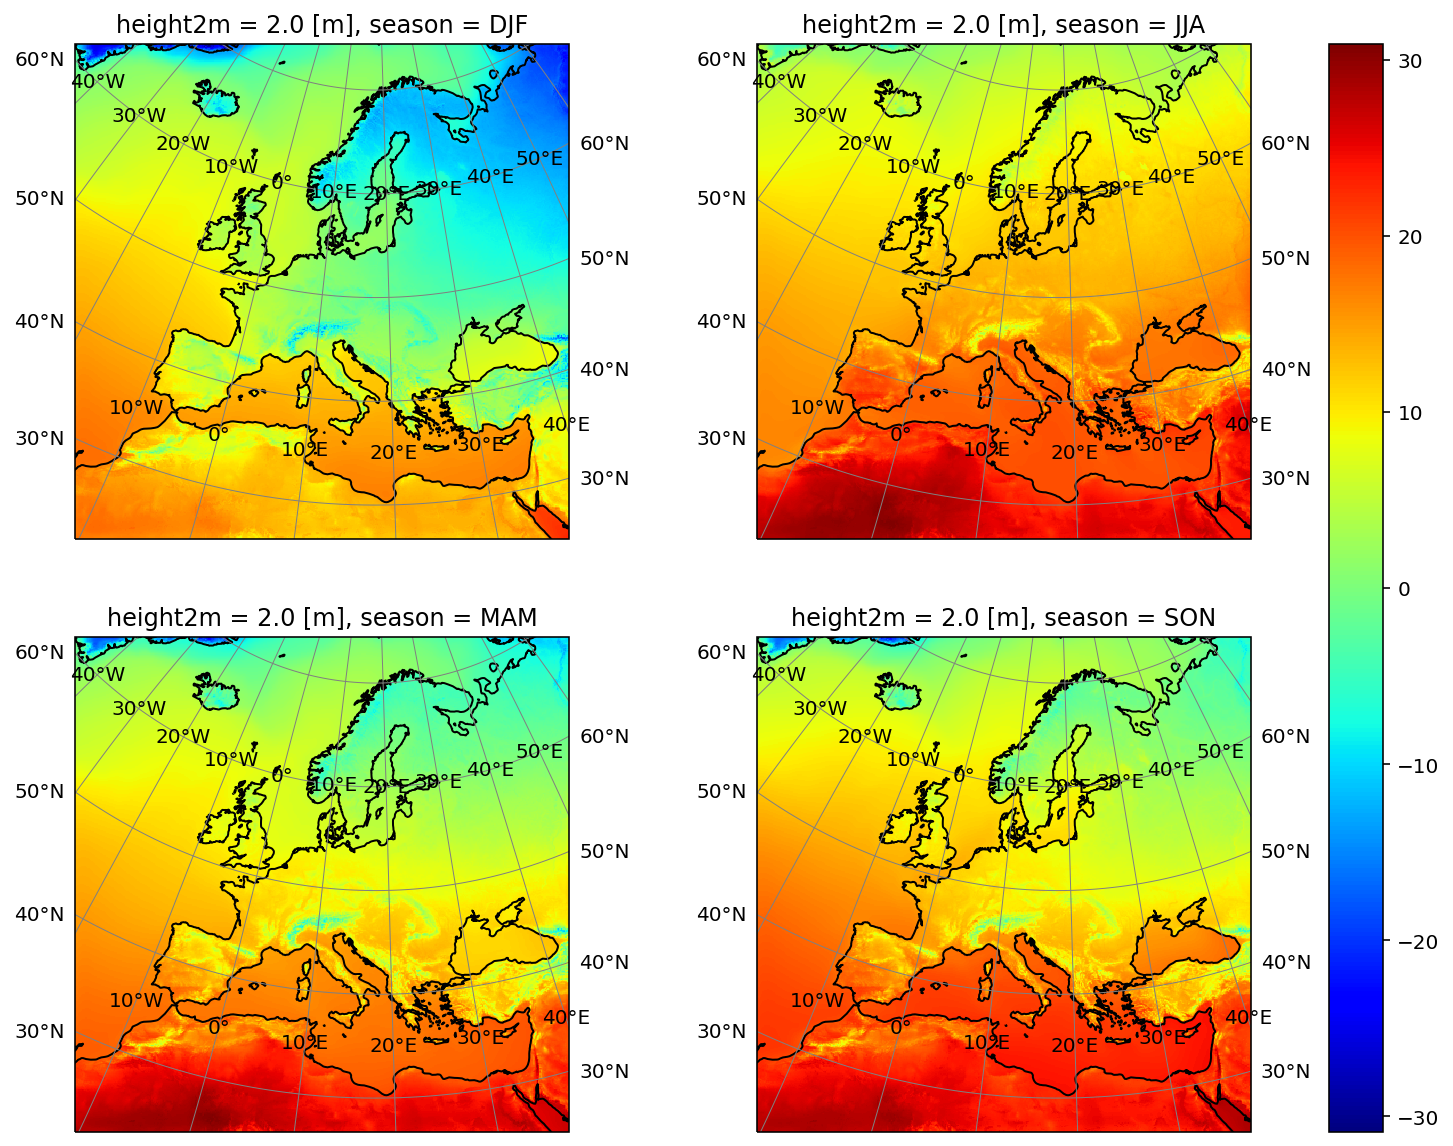

In [20]:
plot_seasons(temp2_seasmean_ - 273.5, transform=rotated_pole, cmap="jet")

## Comparison with observations

This is the exciting part. Let's compare our model results with gridded observational data! We will start with [CRU TS4](https://catalogue.ceda.ac.uk/uuid/89e1e34ec3554dc98594a5732622bce9).

### CRU TS4

In [22]:
cru_base = "/work/ch0636/remo/analysis/observations/cru/TS4.04/original/cru_ts4.04.1901.2019.{var}.dat.nc"
cru_tmp = xr.open_dataset(cru_base.format(var="tmp"), chunks="auto", use_cftime=True)

In [23]:
cru_tmp

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, time: 1428)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) object 1901-01-16 00:00:00 ... 2019-12-16 00:00:00
Data variables:
    tmp      (time, lat, lon) float32 dask.array<chunksize=(476, 120, 240), meta=np.ndarray>
    stn      (time, lat, lon) float64 dask.array<chunksize=(476, 120, 240), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.04 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2004151855. Data generated from:tmp.2004011744.dtb
    history:      Wed 15 Apr 2020 19:58:33 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

We will also add a mask for the `CRU` temperature that is used by the regridder. We create a land sea mask simply from valid temperatures here.

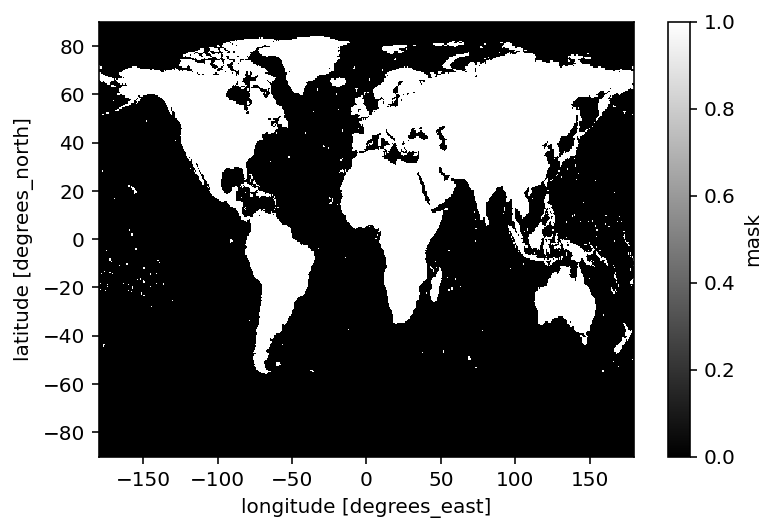

In [24]:
cru_tmp["mask"] = xr.where(~np.isnan(cru_tmp.tmp.isel(time=0)), 1, 0)
cru_tmp.mask.plot(cmap="binary_r")

The CRU data has a resolutio of roughly 50 km. To compare out REMO output with the CRU data, we will regrid the model data to the coarser CRU grid to avoid creating *artificial* observations.

In [25]:
import xesmf as xe

In [26]:
%time regridder = xe.Regridder(ds, cru_tmp, "bilinear")
regridder

CPU times: user 3.24 s, sys: 48.7 ms, total: 3.29 s
Wall time: 3.41 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_433x433_360x720.nc 
Reuse pre-computed weights? False 
Input grid shape:           (433, 433) 
Output grid shape:          (360, 720) 
Periodic in longitude?      False

In [31]:
remo_ts_regrid = regridder(ds.TEMP2)

Now, we compute seasonal means and difference between REMO and CRU. We will choose about 30 years from both datasets.

In [32]:
cru_seasmean = (
    cru_tmp.tmp.sel(time=slice("1979", "2010")).groupby("time.season").mean("time")
)
remo_seasmean = (
    remo_ts_regrid.sel(time=slice("1979", "2010")).groupby("time.season").mean("time")
    - 273.5
)
diff1 = cru_seasmean - remo_seasmean

and finally, we trigger the computation:

In [33]:
%time diff1_ = diff1.compute()

CPU times: user 2.51 s, sys: 186 ms, total: 2.7 s
Wall time: 10.1 s


<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/pyremo-dev/lib/python3.9/site-packages/matplotlib/pyplot.py'>

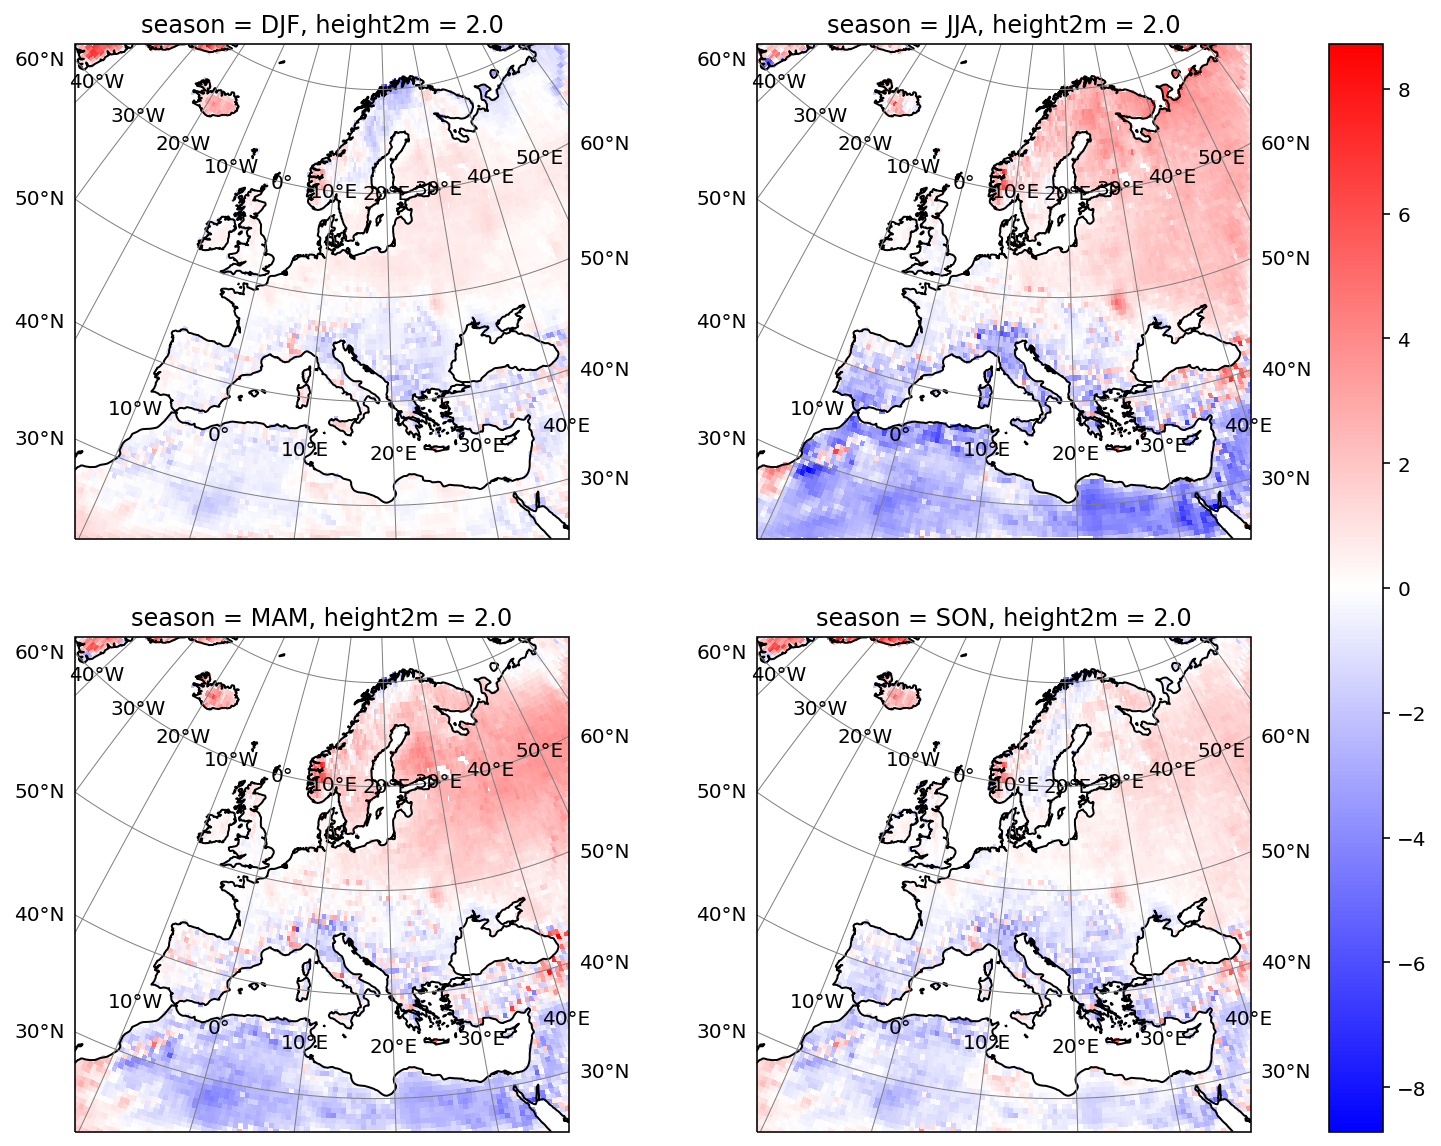

In [34]:
plot_seasons(
    diff1_, transform=ccrs.PlateCarree(), projection=rotated_pole, extent=extent
)

#### Height correction

We will add a height correction based on the different topographies. Let's define a function for this:

In [35]:
def height_correction(height1, height2):
    """Returns height correction in [K].

    Parameters
    ------------

    height1: array like
        topography of model data [m]
    height2: array like
        topography of *true* data [m], e.g., observations

    Returns
    --------

    height correction: array like
        temperature height correction due to different topographies
    """
    return (height2 - height1) * 0.0065

Let's load the topography data for the `CRU` dataset.

In [36]:
cru_topo = xr.open_dataset(
    "/work/ch0636/remo/analysis/observations/cru/TS4.04/original/cru404_c129.nc"
).topo
cru_topo

<xarray.DataArray 'topo' (lat: 360, lon: 720)>
[259200 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    units:    m

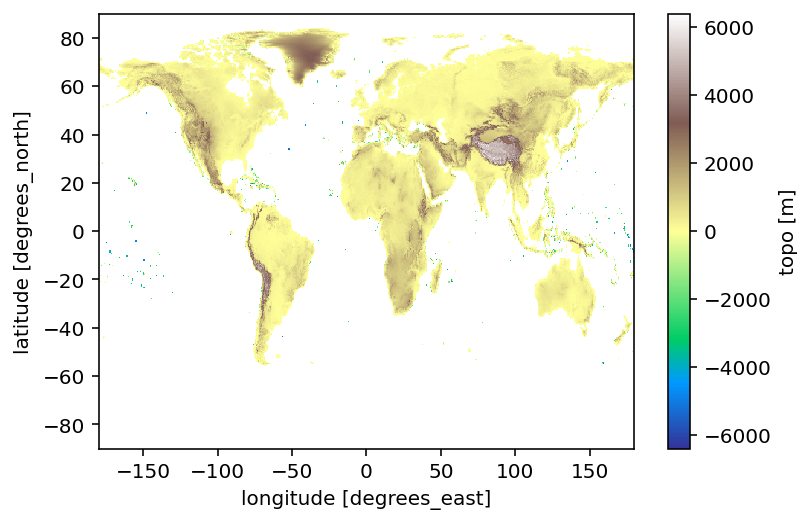

In [37]:
cru_topo.plot(cmap="terrain")

For the height correction, we also have to regrid the REMO topography to the CRU grid:

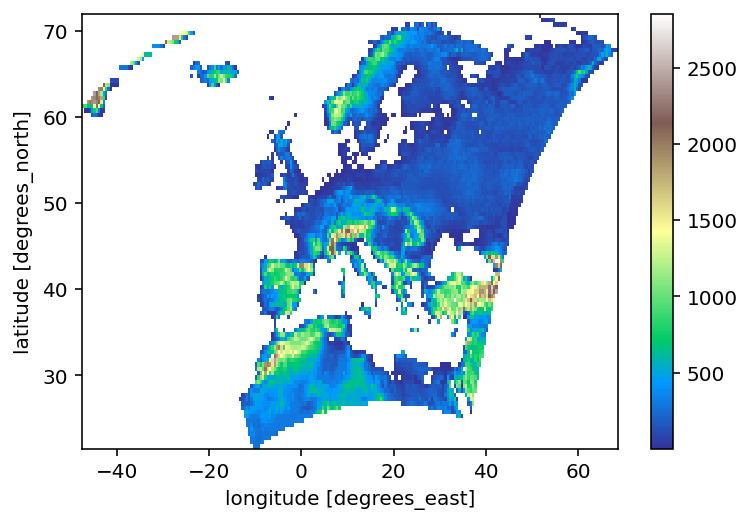

In [38]:
remo_topo_regrid = regridder(ds.topo)
remo_topo_regrid.where(remo_topo_regrid > 0, drop=True).plot(cmap="terrain")

Let's have at look at the height correction:

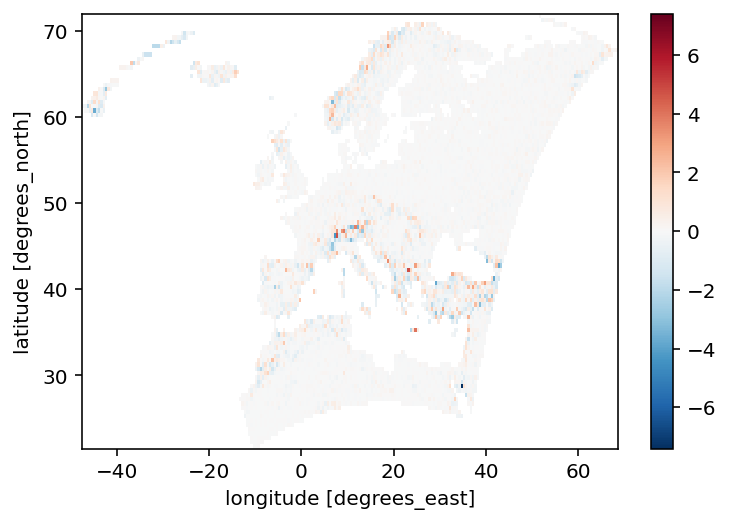

In [39]:
correction = height_correction(remo_topo_regrid, cru_topo)
correction.where(~correction.isnull(), drop=True).plot()

In [40]:
cru_seasmean = (
    cru_tmp.tmp.sel(time=slice("1979", "2010")).groupby("time.season").mean("time")
)
remo_seasmean = (remo_ts_regrid.sel(time=slice("1979", "2010")) + correction).groupby(
    "time.season"
).mean("time") - 273.5
diff2 = cru_seasmean - remo_seasmean
# plot_seasons(diff2.where(mask > 0, drop=True), pole, vmin=-8, vmax=8)

In [41]:
%time diff2_ = diff2.compute()

CPU times: user 3.73 s, sys: 156 ms, total: 3.89 s
Wall time: 11 s


Now, let's look at the bias difference that we get from the height correction

In [42]:
abs(diff2_ - diff1_).max()

<xarray.DataArray ()>
array(7.407959, dtype=float32)

and finally plot our comparison including the height correction

<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/pyremo-dev/lib/python3.9/site-packages/matplotlib/pyplot.py'>

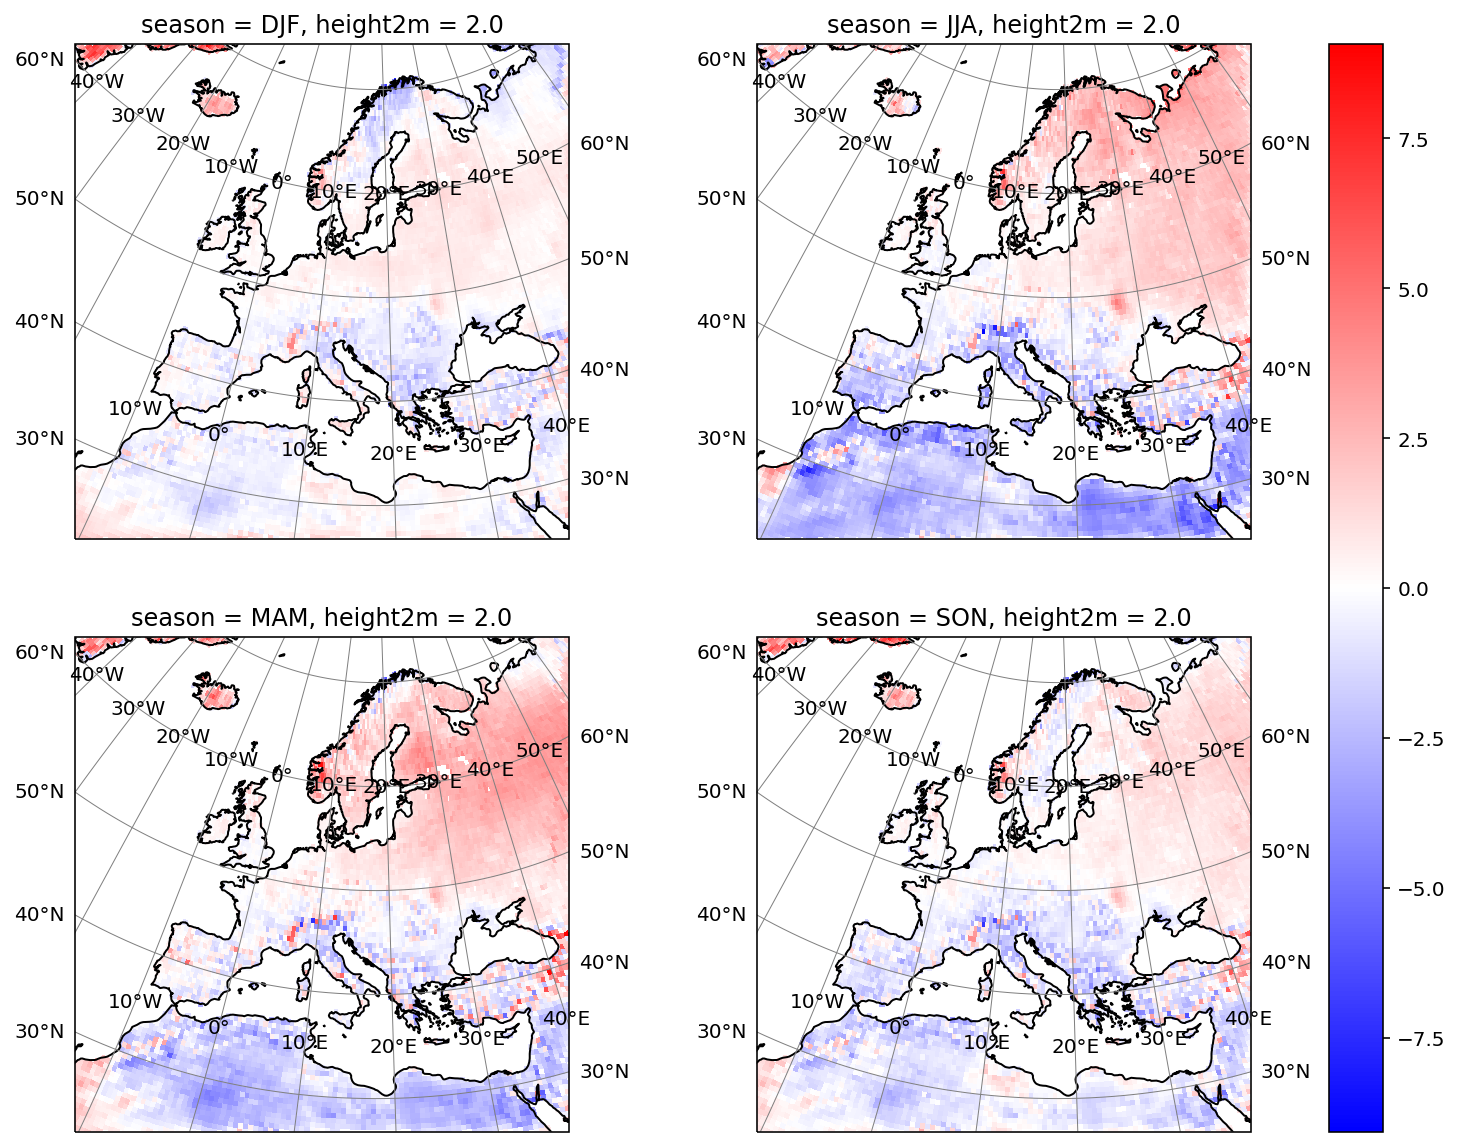

In [43]:
plot_seasons(
    diff2_, transform=ccrs.PlateCarree(), projection=rotated_pole, extent=extent
)

### E-OBS

Now, we will compare the REMO dataset to the [E-OBS dataset](https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php) which is a observational gridded dataset dedicated to Europe. The workflow is exactly the same here:

In [44]:
eobs_base = "/work/ch0636/remo/analysis/observations/eobs/v22.0e/original_025/day/var/tas/tg_ens_mean_0.25deg_reg_v22.0e.nc"
eobs_tg = xr.open_dataset(
    eobs_base, chunks={"time": 1, "latitude": 201, "longitude": 464}, use_cftime=True
)

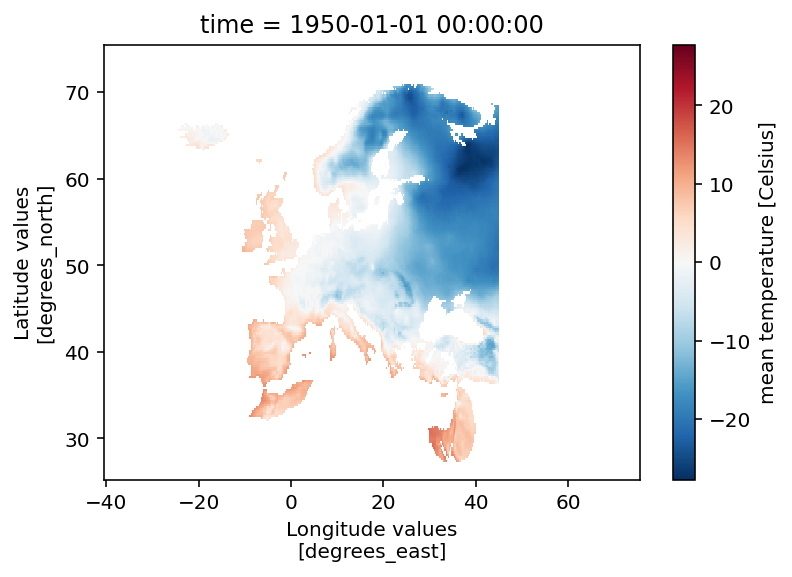

In [45]:
eobs_tg.tg.isel(time=0).plot()

We also add a mask for valid temperature values.

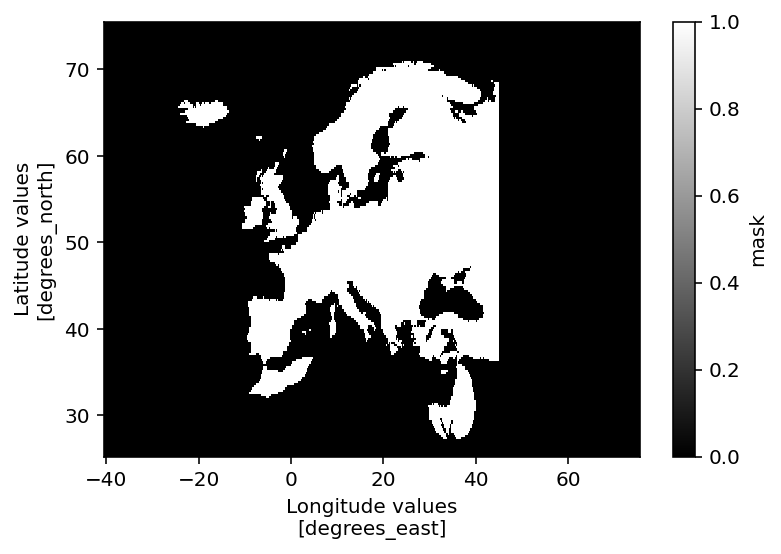

In [46]:
eobs_tg["mask"] = xr.where(~np.isnan(eobs_tg.tg.isel(time=0)), 1, 0)
eobs_tg.mask.plot(cmap="binary_r")

In [47]:
%time regridder = xe.Regridder(ds, eobs_tg, "bilinear")
regridder

CPU times: user 2.01 s, sys: 45.4 ms, total: 2.06 s
Wall time: 2.08 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_433x433_201x464.nc 
Reuse pre-computed weights? False 
Input grid shape:           (433, 433) 
Output grid shape:          (201, 464) 
Periodic in longitude?      False

In [48]:
remo_ts_regrid = regridder(ds.TEMP2)

In [49]:
eobs_seasmean = (
    eobs_tg.tg.sel(time=slice("1979", "2010")).groupby("time.season").mean("time")
)
remo_seasmean = (
    remo_ts_regrid.sel(time=slice("1979", "2010")).groupby("time.season").mean("time")
    - 273.5
)
diff1 = eobs_seasmean - remo_seasmean

In [50]:
%time diff1_ = diff1.compute()

CPU times: user 23.1 s, sys: 581 ms, total: 23.7 s
Wall time: 25.4 s


<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/pyremo-dev/lib/python3.9/site-packages/matplotlib/pyplot.py'>

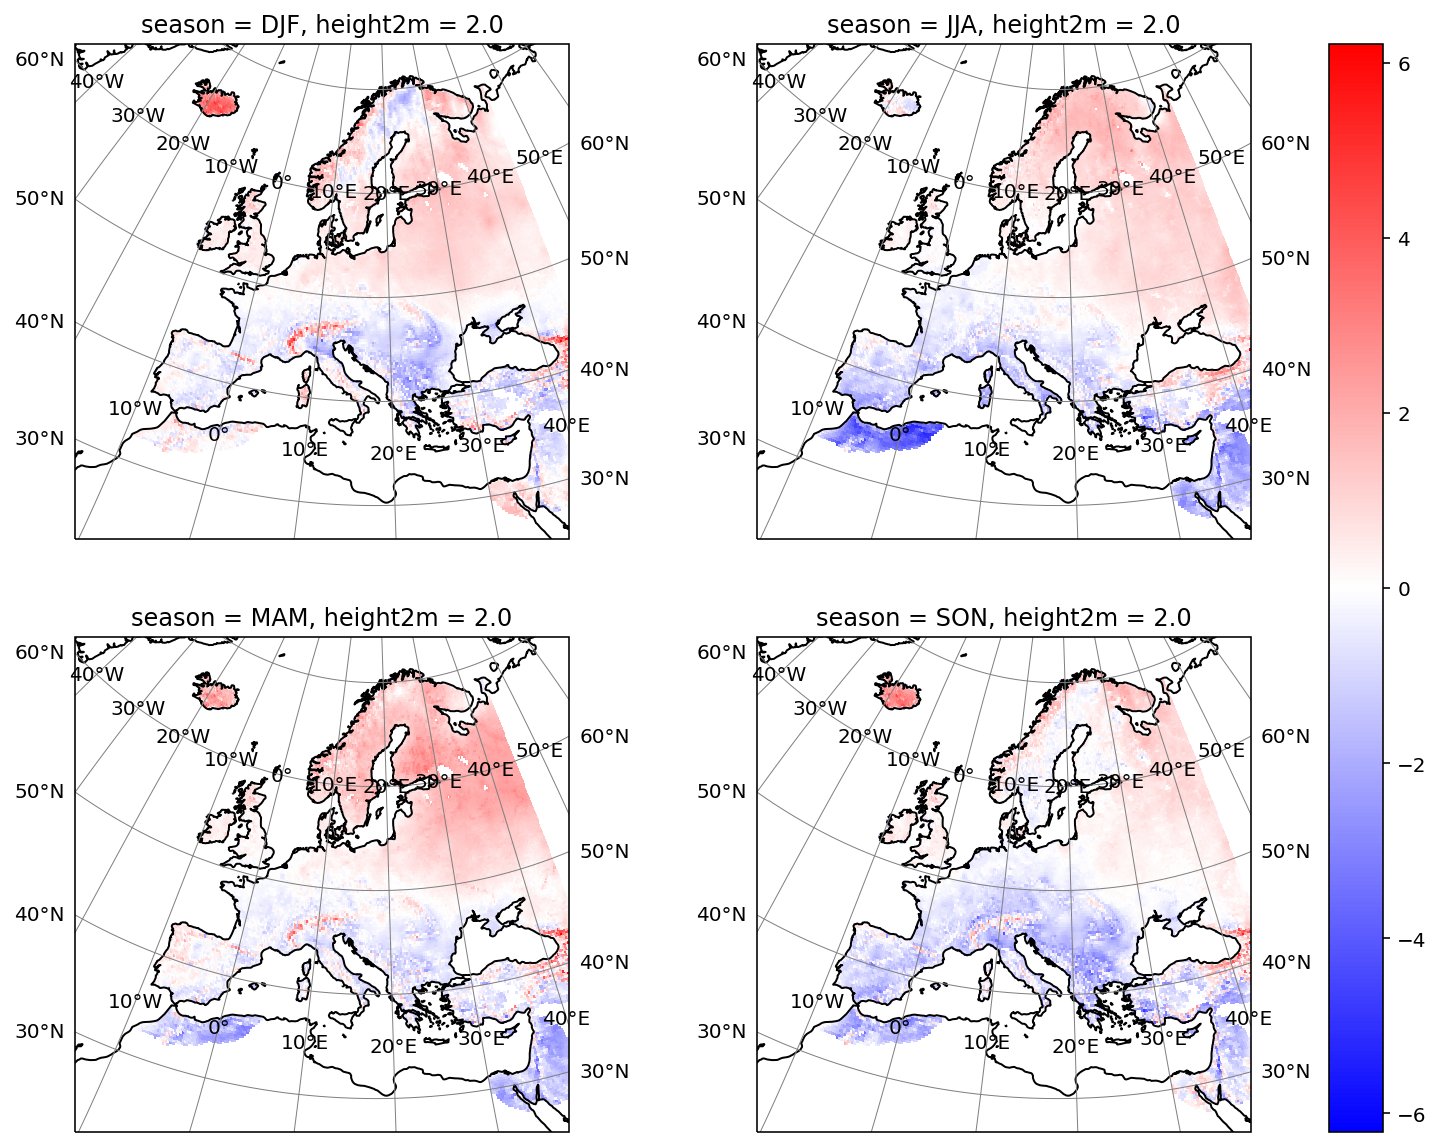

In [51]:
plot_seasons(
    diff1_, transform=ccrs.PlateCarree(), projection=rotated_pole, extent=extent
)

### HYRAS

We can also use even more specialized observational datasets. In this case, we will use the HYRAS dataset which has a resolution of about 5 km. In this case, we should actually regrid the observational dataset to the model grid.

In [52]:
hyras_tas = xr.open_mfdataset(
    "/work/ch0636/remo/analysis/observations/hyras/tas/*", parallel=True
)
hyras_tas

<xarray.Dataset>
Dimensions:  (Y: 220, X: 240, time: 23741)
Coordinates:
    lon      (Y, X) float32 dask.array<chunksize=(220, 240), meta=np.ndarray>
    lat      (Y, X) float32 dask.array<chunksize=(220, 240), meta=np.ndarray>
  * time     (time) datetime64[ns] 1951-01-01 1951-01-02 ... 2015-12-31
Dimensions without coordinates: Y, X
Data variables:
    crs      (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    tas      (time, Y, X) float32 dask.array<chunksize=(365, 220, 240), meta=np.ndarray>
Attributes: (12/15)
    CDI:             Climate Data Interface version 1.8.2 (http://mpimet.mpg....
    Conventions:     CF-1.6
    history:         Mon Jul 09 12:20:58 2018: cdo -ifnotthen -eqc,11 /kp/kp0...
    source:          surface observation
    institution:     Deutscher Wetterdienst
    title:           gridded_mean_temperature_dataset_(HYRAS-TAS)
    ...              ...
    references:      Datenlieferung2018_AP101b_HYRAS-TAS.pdf
    creation_date:   2018-02-16 13:09:04
    conventions:     CF-1.6
    conventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    tracking_id:     aa16c4de-9a66-4a83-a191-d8779538c721
    CDO:             Climate Data Operators version 1.8.2 (http://mpimet.mpg....

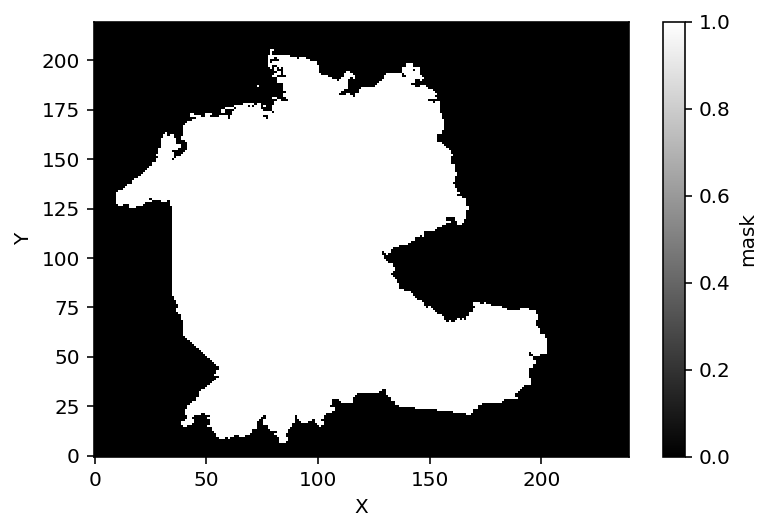

In [53]:
hyras_tas["mask"] = xr.where(~np.isnan(hyras_tas.tas.isel(time=0)), 1, 0)
hyras_tas.mask.plot(cmap="binary_r")

In [54]:
%time regridder = xe.Regridder(hyras_tas, ds, "bilinear")
regridder

CPU times: user 1.1 s, sys: 17 ms, total: 1.11 s
Wall time: 1.3 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_220x240_433x433.nc 
Reuse pre-computed weights? False 
Input grid shape:           (220, 240) 
Output grid shape:          (433, 433) 
Periodic in longitude?      False

In [55]:
hyras_tas_regrid = regridder(hyras_tas.tas)

In [56]:
hyras_tas_seasmean = (
    hyras_tas_regrid.sel(time=slice("1979", "2010")).groupby("time.season").mean("time")
)
remo_seasmean = (
    ds.TEMP2.sel(time=slice("1979", "2010")).groupby("time.season").mean("time") - 273.5
)

In [57]:
diff1 = hyras_tas_seasmean - remo_seasmean
%time diff1_ = diff1.compute()

CPU times: user 8.74 s, sys: 545 ms, total: 9.29 s
Wall time: 17.2 s


<module 'matplotlib.pyplot' from '/work/ch0636/g300046/conda_envs/pyremo-dev/lib/python3.9/site-packages/matplotlib/pyplot.py'>

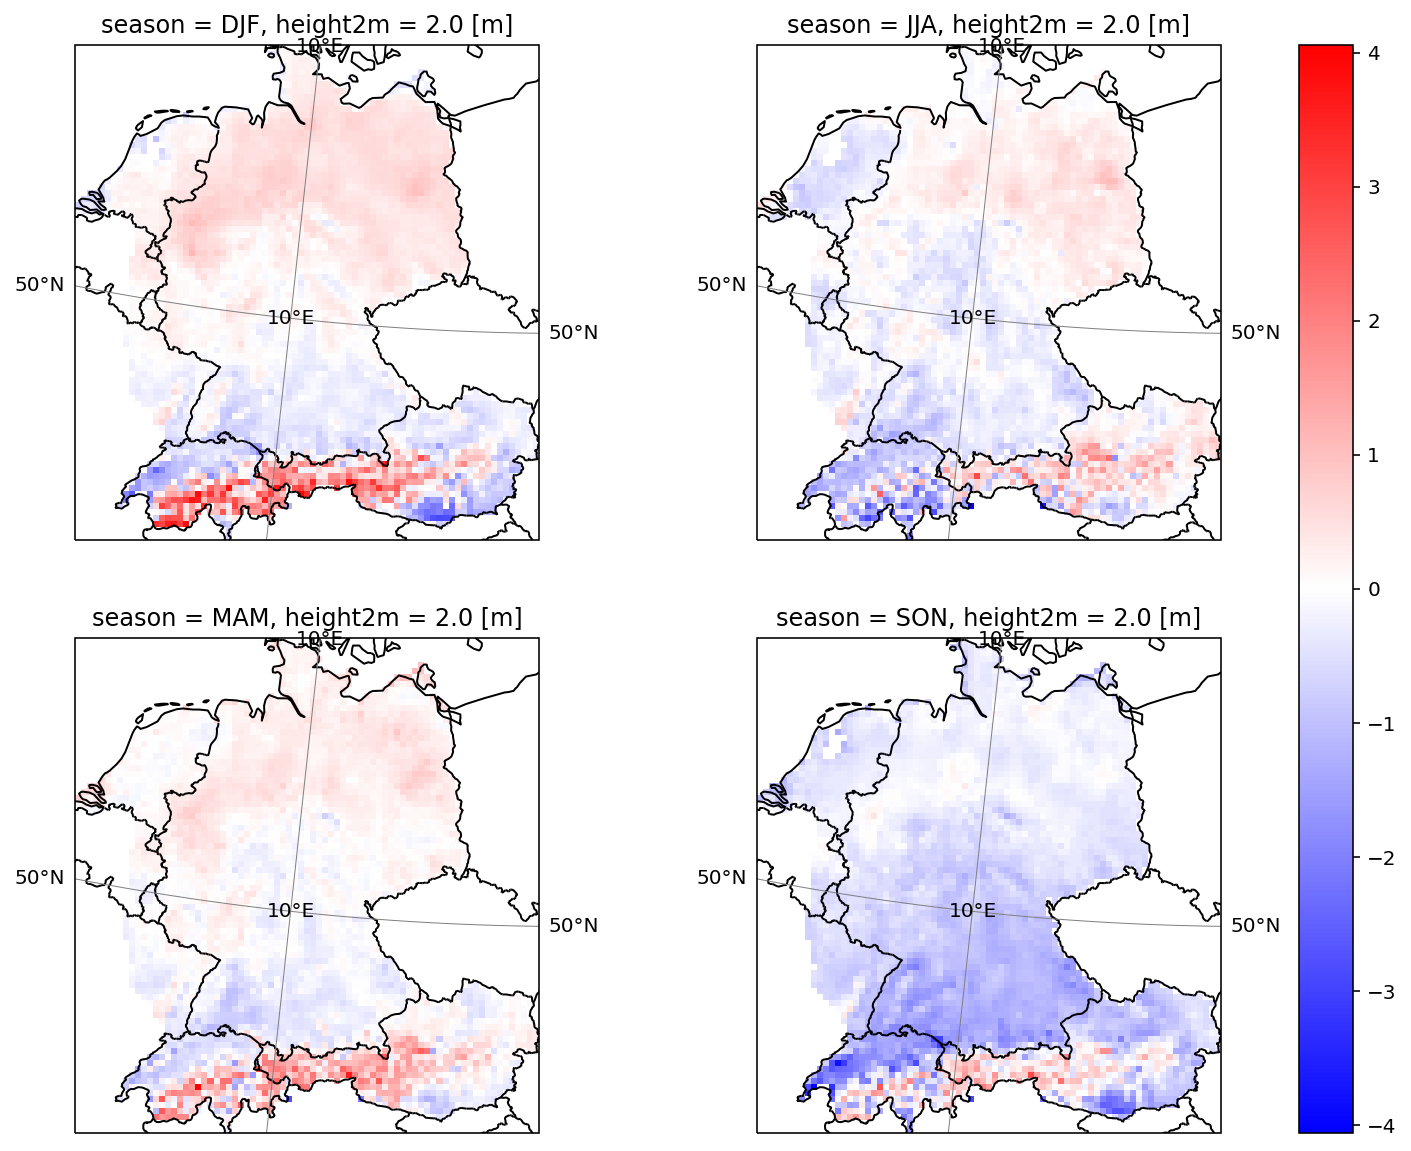

In [58]:
plot_seasons(
    diff1_.where(~diff1_.isnull(), drop=True), transform=rotated_pole, borders=True
)